In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import xgboost as xgb
import pickle
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('new_data.csv')
target = list(data["inflation"])
target = target[1:]
target.append(None)
data["target"] = target
for month_before in range(1,12):
    new_col = list(data["inflation"])
    new_col = new_col[:-month_before]
    for _ in range(month_before):
        new_col = [None, *new_col]
    data[f"inflation_{month_before}m"] = new_col

    new_col = list(data["usd"])
    new_col = new_col[:-month_before]
    for _ in range(month_before):
        new_col = [None, *new_col]
    data[f"usd_{month_before}m"] = new_col

data = data.dropna()
data = data.reset_index(drop=True)

split_1 = -71
split_2 = -26

inflation_scaler = StandardScaler()
usd_scaler = StandardScaler()

inflation_scaler.fit(data[:split_1]['inflation'].to_numpy().reshape(-1,1))
usd_scaler.fit(data[:split_1]['usd'].to_numpy().reshape(-1,1))

scaled_data = data.copy()
for col_name in data.columns:
    if col_name.startswith("inflation") or col_name == 'target':
        scaled_data[col_name] = inflation_scaler.transform(data[col_name].to_numpy().reshape(-1,1))
    elif col_name.startswith("usd"):
        scaled_data[col_name] = usd_scaler.transform(data[col_name].to_numpy().reshape(-1,1))
        
data_12_timestep = data.copy()
data_12_timestep = data[["inflation_11m","inflation_10m","inflation_9m","inflation_8m","inflation_7m",
                        "inflation_6m","inflation_5m","inflation_4m","inflation_3m","inflation_2m",
                        "inflation_1m","inflation"]]

data_12_timestep_usd = data.copy()
data_12_timestep_usd = data[["usd_11m","usd_10m","usd_9m","usd_8m","usd_7m",
                        "usd_6m","usd_5m","usd_4m","usd_3m","usd_2m",
                        "usd_1m","usd"]]

lstm_data = np.empty((len(data_12_timestep_usd),12,2))
for index in range(len(data_12_timestep_usd)):
    for time_index in range(12):
        lstm_data[index][time_index] = np.array([data_12_timestep_usd.iloc[index].to_numpy()[time_index], data_12_timestep.iloc[index].to_numpy()[time_index]])
        
class DataContainer:
    def __init__(self, dataset):
        self.train = dataset[:split_1]
        self.test_1 = dataset[split_1:split_2]
        self.test_2 = dataset[split_2:]
        
months = data["month"]
target = scaled_data["target"]
all_data = scaled_data.copy()
del all_data["target"]
del all_data["month"]
all_data = DataContainer(all_data)
data_12_timestep = DataContainer(data_12_timestep)
data_12_timestep_usd = DataContainer(data_12_timestep_usd)
lstm_data = DataContainer(lstm_data)
target = DataContainer(target)

months_pack = DataContainer(months)

In [3]:
def make_plot(pred, actual,labels):
    plt.plot(inflation_scaler.inverse_transform(pred.reshape(-1,1)).reshape(len(actual)),label="prediction")
    plt.plot(inflation_scaler.inverse_transform(actual.to_numpy().reshape(-1,1)).reshape(len(actual)),label="true value")
    plt.legend()
    plt.xticks(ticks=range(len(actual)),labels=labels,rotation="vertical")
    plt.ylabel("inflation")
    plt.xlabel("month")
    plt.show()

In [4]:
def get_mse(pred, actual):
    return mean_squared_error(inflation_scaler.inverse_transform(pred.reshape(-1,1)).reshape(len(actual)), 
                              inflation_scaler.inverse_transform(actual.to_numpy().reshape(-1,1)).reshape(len(actual)))

In [5]:
def train_model(model_creator, dataset, show_res = True):
    test_count = 10
    scores_train = []
    scores_1 = []
    scores_2 = []
    best_model = None
    best_score = 1e9

    for _ in range(test_count):
        model = model_creator()
        model.fit(dataset.train, target.train)

        scores_train.append(get_mse(model.predict(dataset.train), target.train))
        scores_1.append(get_mse(model.predict(dataset.test_1), target.test_1))
        scores_2.append(get_mse(model.predict(dataset.test_2), target.test_2))

        if scores_1[-1] < best_score:
            best_score = scores_1[-1]
            best_model = model

    if show_res:
        print(sum(scores_train)/test_count)
        print(sum(scores_1)/test_count)
        print(sum(scores_2)/test_count)
        make_plot(best_model.predict(dataset.train), target.train, months_pack.train)
        make_plot(best_model.predict(dataset.test_1), target.test_1, months_pack.test_1)
        make_plot(best_model.predict(dataset.test_2), target.test_2, months_pack.test_2)

    return best_model, best_score

In [6]:
def score_model(model, dataset):
    print("Train", get_mse(model.predict(dataset.train), target.train))
    print("Test 1", get_mse(model.predict(dataset.test_1), target.test_1))
    print("Test 2", get_mse(model.predict(dataset.test_2), target.test_2))
    print("All test", get_mse(model.predict(pd.concat((dataset.test_1, dataset.test_2))), 
                              pd.concat((target.test_1, target.test_2))))

# KNN

0.4615832667586598
1.1416281179138303
26.226624803767642


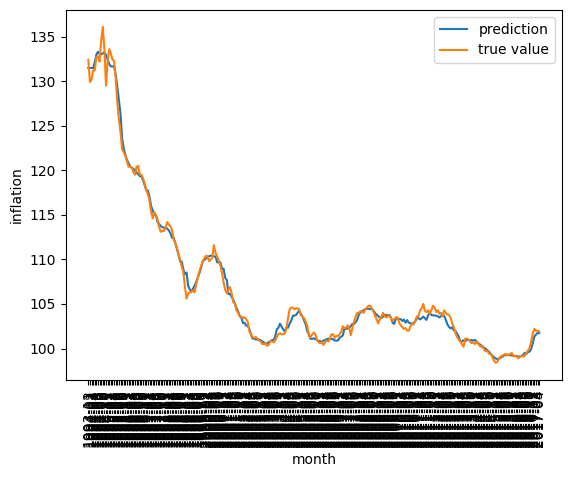

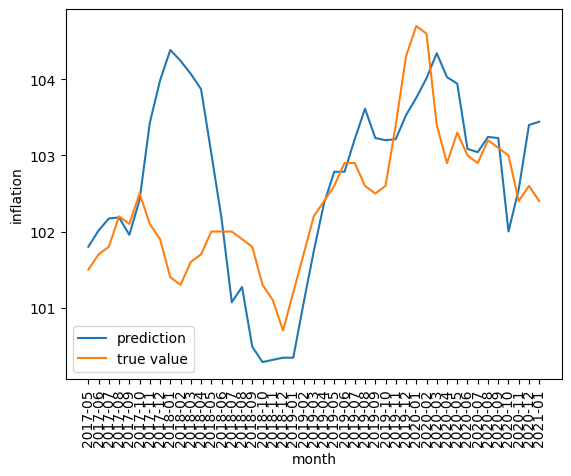

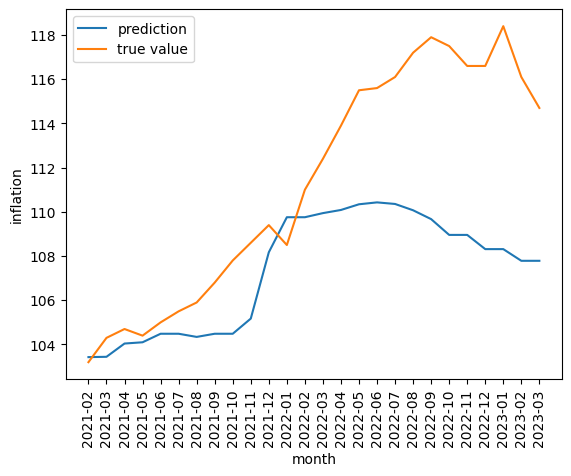

In [7]:
best_model = train_model(lambda: KNeighborsRegressor(n_neighbors=7, metric="cityblock"), all_data)

In [8]:
score_model(best_model[0], all_data)

Train 0.4615832667586599
Test 1 1.1416281179138303
Test 2 26.226624803767645
All test 10.327683242311002


In [9]:
with open("knn","wb") as file:
    pickle.dump(best_model[0],file)

# CatBoost

0.4961638980720958
0.21298465441265085
17.02957785150363


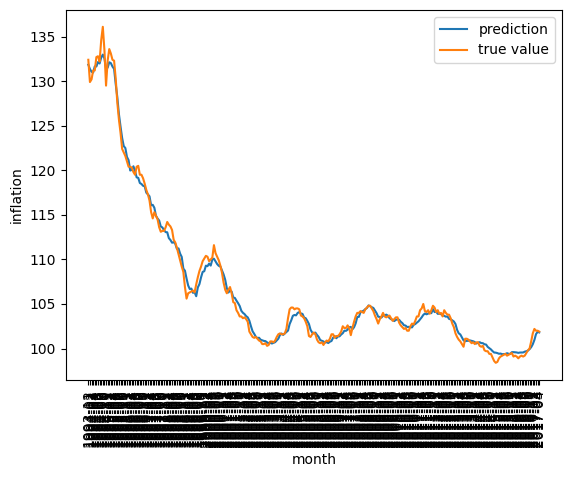

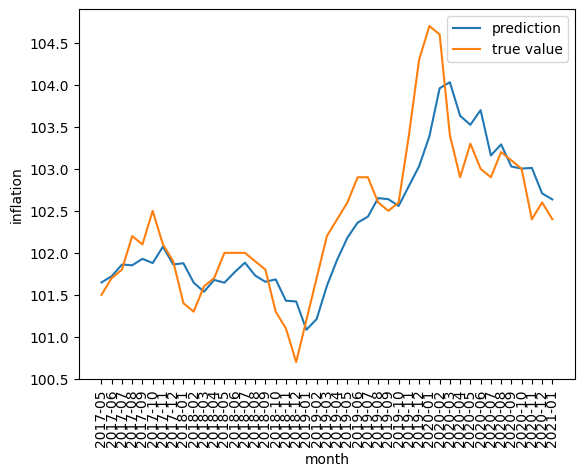

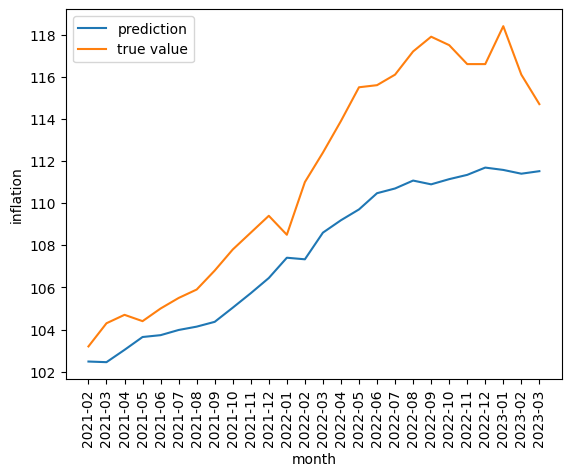

In [10]:
curr_model = train_model(lambda: CatBoostRegressor(depth=4, n_estimators=200, learning_rate=0.03,silent=True), all_data, show_res=True)

In [11]:
score_model(curr_model[0], all_data)

Train 0.4961638980720957
Test 1 0.21298465441265088
Test 2 17.029577851503625
All test 6.371173712502302


In [12]:
curr_model[0].save_model("catboost")

# XGB

0.0427678877728977
0.16165246442513945
5.701068268904035


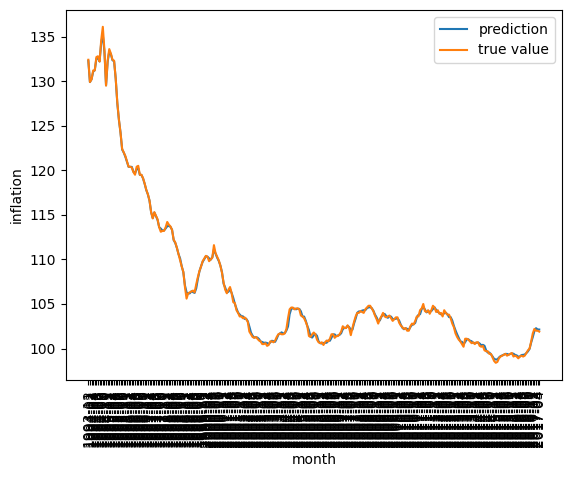

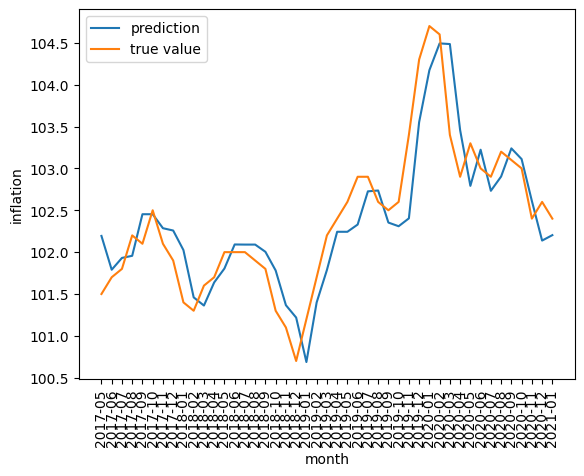

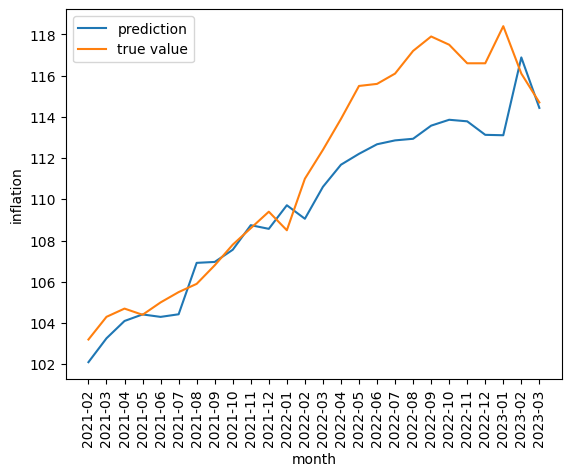

In [13]:
curr_model = train_model(lambda: xgb.XGBRegressor(max_depth=4, 
                                                  n_estimators=200,
                                                  learning_rate=0.03,
                                                  verbosity=0), all_data, show_res=True)

In [14]:
score_model(curr_model[0], all_data)

Train 0.0427678877728977
Test 1 0.16165246442513947
Test 2 5.701068268904034
All test 2.190170928037129


In [15]:
with open("xgb","wb") as file:
    pickle.dump(curr_model[0],file)

# Random forest

0.1319757338136078
0.17473684264558978
12.915348400410533


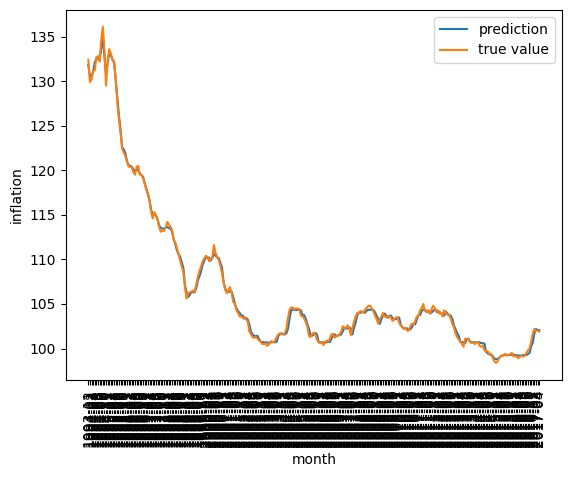

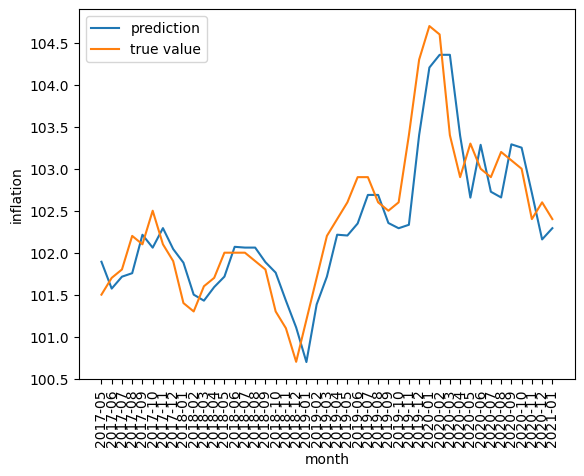

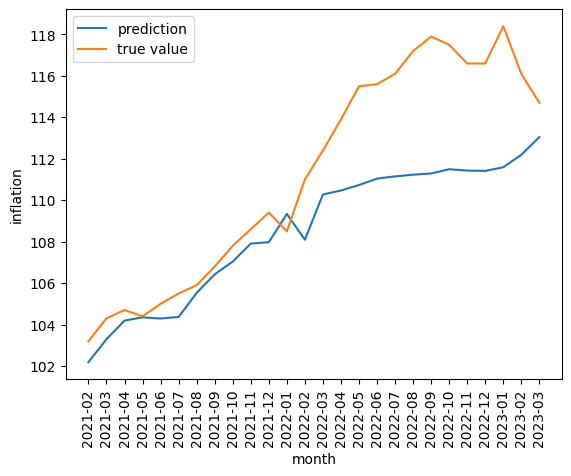

In [16]:
curr_model = train_model(lambda: RandomForestRegressor(max_depth=5, 
                                                  n_estimators=200), all_data, show_res=True)

In [17]:
score_model(curr_model[0], all_data)

Train 0.12501741301839056
Test 1 0.16558653241012397
Test 2 12.853853386802228
All test 4.811994112891739


In [18]:
with open("rf","wb") as file:
    pickle.dump(curr_model[0],file)

In [19]:
def make_plot(pred, actual,labels):
    plt.plot(inflation_scaler.inverse_transform(pred).reshape(len(actual)),label="prediction")
    plt.plot(inflation_scaler.inverse_transform(actual.to_numpy().reshape(-1,1)).reshape(len(actual)),label="true value")
    plt.legend()
    plt.xticks(ticks=range(len(actual)),labels=labels,rotation="vertical")
    plt.ylabel("inflation")
    plt.xlabel("month")
    plt.show()

In [20]:
def get_mse(pred, actual):
    return mean_squared_error(inflation_scaler.inverse_transform(pred).reshape(len(actual)), 
                              inflation_scaler.inverse_transform(actual.to_numpy().reshape(-1,1)).reshape(len(actual)))

In [21]:
def train_model(model_creator, dataset, show_res = True):
    test_count = 10
    scores_train = []
    scores_1 = []
    scores_2 = []
    best_model = None
    best_score = 1e9

    for _ in range(test_count):
        model = model_creator()
        model.fit(dataset.train, target.train, epochs=40, batch_size=32, verbose=0)

        scores_train.append(get_mse(model.predict(dataset.train), target.train))
        scores_1.append(get_mse(model.predict(dataset.test_1), target.test_1))
        scores_2.append(get_mse(model.predict(dataset.test_2), target.test_2))

        if scores_1[-1] < best_score:
            best_score = scores_1[-1]
            best_model = model

    if show_res:
        print(sum(scores_train)/test_count)
        print(sum(scores_1)/test_count)
        print(sum(scores_2)/test_count)
        make_plot(best_model.predict(dataset.train), target.train, months_pack.train)
        make_plot(best_model.predict(dataset.test_1), target.test_1, months_pack.test_1)
        make_plot(best_model.predict(dataset.test_2), target.test_2, months_pack.test_2)

    return best_model, best_score

# NN

In [22]:
def make_nn():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(24,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

1/1 [==============================] - 0s 21ms/step
0.6772971188855809
0.50454700276015
6.93865268119517
9/9 [==============================] - 0s 1ms/step


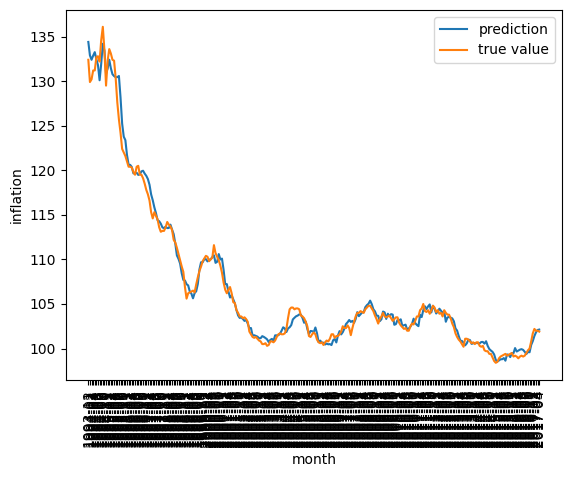

2/2 [==============================] - 0s 2ms/step


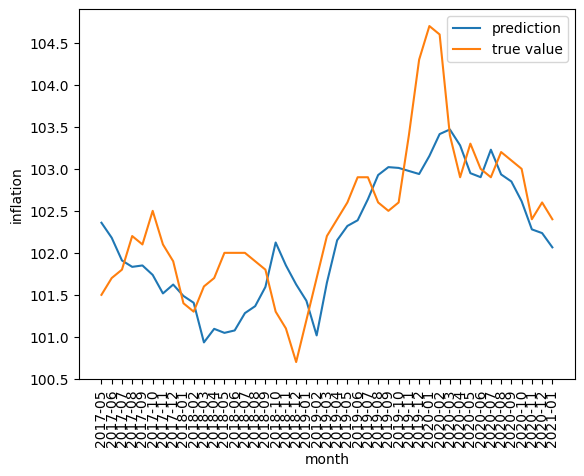

1/1 [==============================] - 0s 20ms/step


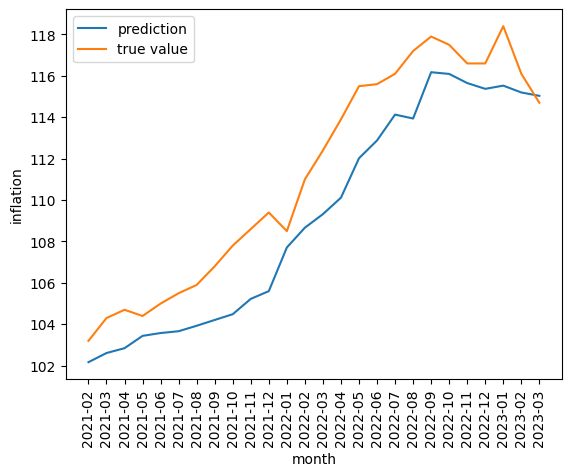

In [23]:
best_model = train_model(make_nn, all_data, show_res = True)

In [24]:
score_model(best_model[0], all_data)

9/9 [==============================] - 0s 1ms/step
Train 0.7703172300075636
2/2 [==============================] - 0s 2ms/step
Test 1 0.36246467872481397
1/1 [==============================] - 0s 21ms/step
Test 2 5.443903310117941
3/3 [==============================] - 0s 2ms/step
All test 2.22327319162934


In [25]:
best_model[0].save("nn.keras")

In [26]:
def score_model(model, dataset):
    print("Train", get_mse(model.predict(dataset.train), target.train))
    print("Test 1", get_mse(model.predict(dataset.test_1), target.test_1))
    print("Test 2", get_mse(model.predict(dataset.test_2), target.test_2))
    print("All test", get_mse(model.predict(np.vstack((dataset.test_1, dataset.test_2))), 
                              pd.Series(np.hstack((target.test_1, target.test_2)))))

# LSTM

In [27]:
def make_nn():
    model = Sequential()
    model.add(LSTM(32, input_shape=(12, 2), return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

1/1 [==============================] - 0s 24ms/step
4.629659348165022
1.0910611757888304
46.16674581929312
9/9 [==============================] - 0s 6ms/step


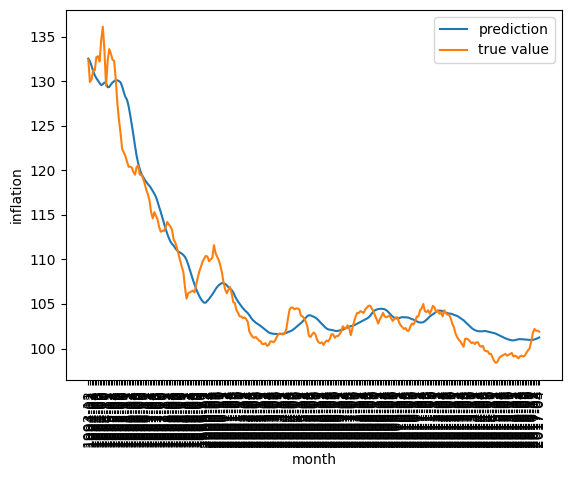

2/2 [==============================] - 0s 6ms/step


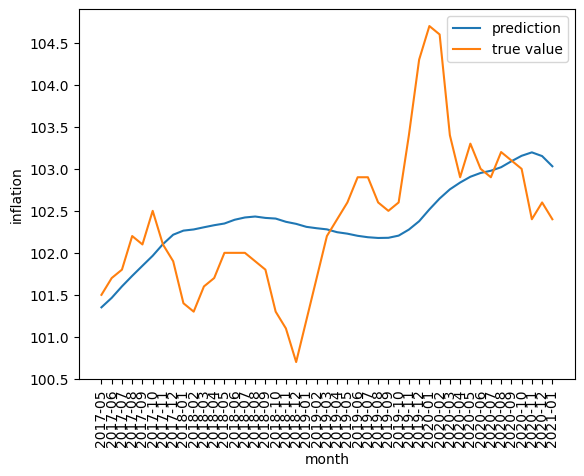

1/1 [==============================] - 0s 25ms/step


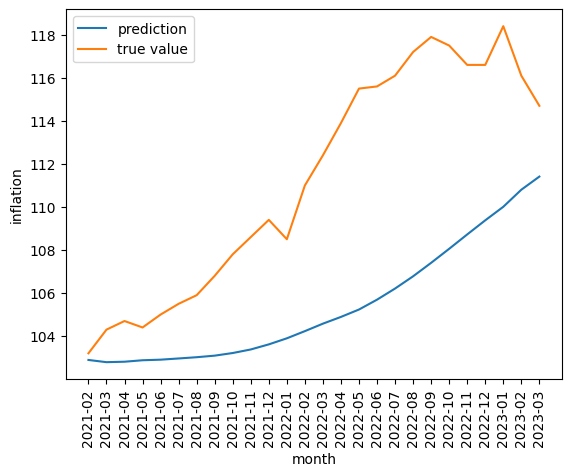

In [28]:
best_model = train_model(make_nn, lstm_data, show_res = True)

In [29]:
score_model(best_model[0], lstm_data)

9/9 [==============================] - 0s 6ms/step
Train 4.653600999091187
2/2 [==============================] - 0s 5ms/step
Test 1 0.6390127175555871
1/1 [==============================] - 0s 25ms/step
Test 2 44.81528935991192
3/3 [==============================] - 0s 5ms/step
All test 16.81623865814043


In [30]:
best_model[0].save("lstm.keras")